### Imports

In [ ]:
import os, glob, sys, pickle
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Dict, List


print("PyTorch built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "—")

PyTorch built with CUDA: 12.4
CUDA available: True
GPU name: NVIDIA GeForce RTX 4070


### Config

In [ ]:
INPUT_DIR = r"./historical_1h_data"
OUTPUT_DIR = r"./prediction_model"

SEQ_LEN = 24 # hours of past context
STRIDE = 1 # hop size between windows
PRED_HORIZON = 3 # hours ahead
THRESH_PCT = 0.01 # +-1% band (since we are competing against a 1% sale tax)
GRID_SWEEP = np.linspace(0.50, 0.95, 25) # candidate τ values

BATCH_SIZE = 256
EPOCHS = 40
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

METRIC_BETA = 0.1

IGNORE_IDX = -100

### Data filter + feature engineering functions

In [ ]:
START = pd.Timestamp("2025-04-01")
END = pd.Timestamp("2025-05-29 23:59:59")

def load_and_filter(start=START, end=END) -> List[pd.DataFrame]:
    csv_files = glob.glob(os.path.join(INPUT_DIR, "*.csv"))
    item_dfs = []

    # build a complete hourly index and note how many hours that is
    full_idx = pd.date_range(start, end, freq="H")
    total_expected = len(full_idx)

    for fp in tqdm(csv_files, desc="Loading CSVs"):
        df = pd.read_csv(fp)
        if "datetime" not in df.columns:
            continue

        # parse & limit to our window
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
        df = df.dropna(subset=["datetime"])
        df = df[df["datetime"].between(start, end)].sort_values("datetime")

        # if too many missing raw prices, skip entirely
        high_count = df["avgHighPrice"].count()
        low_count  = df["avgLowPrice"].count()
        if (high_count / total_expected < 0.9) or \
           (low_count / total_expected < 0.9):
            continue

        # re‐index to exact hourly grid
        df = df.set_index("datetime").reindex(full_idx)
        df.index.name = "datetime"

        # fill missing prices by carrying forward last known
        df["avgHighPrice"] = df["avgHighPrice"].ffill()
        df["avgLowPrice"] = df["avgLowPrice"].ffill()

        # any originally‐missing volume becomes 0 (no trades that hour)
        df["highPriceVolume"] = df["highPriceVolume"].fillna(0)
        df["lowPriceVolume"] = df["lowPriceVolume"].fillna(0)

        # fill item metadata across the new rows
        df["item_name"] = os.path.splitext(os.path.basename(fp))[0]
        if "item_id" in df.columns:
            df["item_id"] = df["item_id"].ffill().bfill()

        # only keep items that now have exactly total_expected rows
        if len(df) == total_expected:
            item_dfs.append(df.reset_index())

    print(f"{len(item_dfs)} items kept, {len(item_dfs)*total_expected:,} rows.")
    return item_dfs


def engineer_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, list]:
    # price & return features
    # (we already zero‐filled volumes above, so these will be 0 where no trades)

    df["mid"] = (df["avgHighPrice"] + df["avgLowPrice"]) / 2
    df["mid_return_1h"] = np.log(df["mid"]).diff(1)
    df["mid_return_3h"] = np.log(df["mid"]).diff(3)
    df["volatility_6h"] = df["mid"].rolling(6).std()
    df["volatility_24h"] = df["mid"].rolling(24).std()
    df["high_return_1h"] = np.log(df["avgHighPrice"]).diff(1)
    df["low_return_1h"] = np.log(df["avgLowPrice"]).diff(1)
    df["high_return_6h"] = np.log(df["avgHighPrice"]).diff(6)
    df["low_return_6h"] = np.log(df["avgLowPrice"]).diff(6)
    df["no_buys"] = df["lowPriceVolume"].fillna(0).eq(0)
    df["no_sells"] = df["highPriceVolume"].fillna(0).eq(0)

    # volume ratio (safe divide)
    denom = df["highPriceVolume"] + df["lowPriceVolume"]
    df["vol_ratio"] = np.divide(
        df["highPriceVolume"], denom,
        out=np.zeros_like(denom, dtype=float),
        where=denom != 0,
    )
    df["low_volume_return_1h"] = np.log(df["lowPriceVolume"] + 1e-9).diff(1)
    df["high_volume_return_1h"] = np.log(df["highPriceVolume"] + 1e-9).diff(1)

    # cyclical time features

    df["hour"] = df["datetime"].dt.hour
    df["weekday"] = df["datetime"].dt.dayofweek
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["wday_sin"] = np.sin(2*np.pi*df["weekday"]/7)
    df["wday_cos"] = np.cos(2*np.pi*df["weekday"]/7)
    feat_cols = [
        #"avgHighPrice", "avgLowPrice", "mid",
        "high_return_1h", "low_return_1h", "high_return_6h", "low_return_6h",
        "vol_ratio", "low_volume_return_1h", "high_volume_return_1h",
        "volatility_6h", "volatility_24h",
        #"highPriceVolume", "lowPriceVolume",
        "hour_sin", "hour_cos", "wday_sin", "wday_cos",
        "no_buys", "no_sells"
    ]

    # ensure numeric & finite; fill any leftover NaNs in the very first rows
    df[feat_cols] = (
        df[feat_cols]
          .apply(pd.to_numeric, errors="coerce")
          .replace([np.inf, -np.inf], np.nan)
          .ffill().bfill()
    )

    return df, feat_cols

def make_labels(df: pd.DataFrame, horizon: int, thresh_pct: float
                ) -> Tuple[np.ndarray, np.ndarray]:
    high_next = df["avgHighPrice"].shift(-horizon)
    low_next  = df["avgLowPrice"].shift(-horizon)

    def label(curr, nxt):
        pct = (nxt - curr) / curr
        return np.where(pct >  thresh_pct, 2, # up
               np.where(pct < -thresh_pct, 0, 1)).astype(np.int64)

    y_high = label(df["avgHighPrice"], high_next)
    y_low  = label(df["avgLowPrice"], low_next)
    y_high[-horizon:] = -1
    y_low [-horizon:] = -1
    return y_high, y_low

### Torch dataset class

In [44]:
class PriceSequenceDataset(Dataset):
    def __init__(self,
                 arrays: List[np.ndarray],
                 labels_high: List[np.ndarray],
                 labels_low: List[np.ndarray],
                 item_idxs: List[np.ndarray],
                 seq_len: int,
                 seq_stride: int = 1):
        # 1) flatten all data
        self.X = np.concatenate(arrays,   axis=0)
        self.yH = np.concatenate(labels_high, axis=0)
        self.yL = np.concatenate(labels_low,  axis=0)
        self.item_i = np.concatenate(item_idxs,   axis=0)
        self.seq_len = seq_len
        self.stride = seq_stride

        # 2) build per-item boundaries so windows never cross items
        boundaries = []
        offset = 0
        for item_idx, arr in enumerate(arrays):
            n = arr.shape[0]
            boundaries.append((offset, offset + n, item_idx))
            offset += n

        # 3) collect only those idxs where a full seq_len history exists
        valid_idx = []
        for start, end, _ in boundaries:
            # allow windows [i-seq_len, i) for i in [start+seq_len, end)
            valid_idx.extend(range(start + seq_len, end, self.stride))
        self.valid_idx = np.array(valid_idx, dtype=np.int64)

    def __len__(self):
        return len(self.valid_idx)

    def __getitem__(self, i):
        idx = self.valid_idx[i]
        x = self.X[idx-self.seq_len:idx]
        iid = self.item_i[idx]
        return (
            torch.from_numpy(x).float(),
            torch.tensor(self.yH[idx], dtype=torch.long),
            torch.tensor(self.yL[idx], dtype=torch.long),
            torch.tensor(iid, dtype=torch.long),
        )

### Model

In [45]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_features, n_items,
                 id_emb_dim=1, hidden_size=24, dropout=0.3):
        super().__init__()

        self.id_emb = nn.Embedding(n_items, id_emb_dim)

        self.lstm = nn.LSTM(
            input_size=n_features + id_emb_dim,
            hidden_size=hidden_size,
            num_layers=2,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.head_high = nn.Linear(hidden_size*2, 3)
        self.head_low = nn.Linear(hidden_size*2, 3)

    def forward(self, x, item_id):
        B, T, _ = x.shape
        id_vec = self.id_emb(item_id).unsqueeze(1).expand(B, T, -1)
        x = torch.cat([x, id_vec], dim=-1)
        _, (h, _) = self.lstm(x)
        h_top = self.dropout(torch.cat([h[-2], h[-1]], dim=1))  # fwd + bwd
        return self.head_high(h_top), self.head_low(h_top)

### Threshold search + metrics

In [ ]:
def directional_metrics(
        y_true,
        y_pred,
        beta=0.5,
        mask=None,
        ignore_idx=IGNORE_IDX,
):
    """
    Precision, recall and F-β for the directional classes 0 (rise) and 2 (fall).

    Parameters:
    y_true, y_pred : array-like of shape (n_samples,)
    beta : float, weighting in F-score
    mask : Boolean array, rows to keep   (optional)
    ignore_idx : int, sentinel for 'skip row' (optional)

    Returns:
    precision, recall, f_beta  (all floats)
    """

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # base mask: keep only real labels 0 or 2
    keep = np.isin(y_true, [0, 2])

    # drop the sentinel if it somehow slipped through
    keep &= (y_true != ignore_idx)

    # apply mask if given
    if mask is not None:
        keep &= np.asarray(mask)

    # nothing to score -> return zeros
    if keep.sum() == 0:
        return 0.0, 0.0, 0.0

    p, r, f, _ = precision_recall_fscore_support(
        y_true[keep],
        y_pred[keep],
        labels=[0, 2],
        average="macro",
        beta=beta,
        zero_division=0,
    )
    return p, r, f


def tune_threshold(y_true,
                   pred_raw,
                   conf,
                   sweep=np.linspace(0.50, 0.95, 25),
                   beta=METRIC_BETA,
                   head="H"):
    """
    Return the **highest** τ that achieves the best directional F-β,
    and print the whole sweep so you can see what's happening.
    """
    best_tau, best_f = None, -1.0

    for τ in sweep:
        pred = np.where(conf < τ, 1, pred_raw)
        _, _, f = directional_metrics(y_true, pred, beta)

        # keep the highest τ that attains the best F
        if (f > best_f + 1e-6) or (abs(f - best_f) < 1e-6 and (best_tau is None or τ > best_tau)):
            best_tau, best_f = τ, f
    
    return best_tau, best_f

### Load & split dataset

In [47]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

item_dfs = load_and_filter()

train_arrays, val_arrays, test_arrays = [], [], []
train_H, val_H, test_H = [], [], []
train_L, val_L, test_L = [], [], []
train_idx, val_idx, test_idx = [], [], []

for item_idx, df in enumerate(item_dfs):
    df, feat_cols = engineer_features(df)

    mask_train = (df["datetime"] <  "2025-05-16")
    mask_val = (df["datetime"] >= "2025-05-16") & (df["datetime"] < "2025-05-23")
    mask_test = (df["datetime"] >= "2025-05-23")

    y_high, y_low = make_labels(df, PRED_HORIZON, THRESH_PCT)
    y_high[df["no_buys"].values] = IGNORE_IDX
    y_low[df["no_sells"].values] = IGNORE_IDX

    def slice_it(mask, store_arrays, store_H, store_L, store_idx):
        sub = df.loc[mask, feat_cols].values
        store_arrays.append(sub)
        m = mask.to_numpy()
        store_H.append(y_high[m])
        store_L.append(y_low[m])
        # a 1D array of the same length as sub, filled with item_idx
        store_idx.append(np.full(sub.shape[0], item_idx, dtype=np.int64))

    slice_it(mask_train, train_arrays, train_H, train_L, train_idx)
    slice_it(mask_val, val_arrays, val_H, val_L, val_idx)
    slice_it(mask_test, test_arrays, test_H, test_L, test_idx)

/tmp/ipykernel_28719/2081467176.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start, end, freq="H")
Loading CSVs: 100%|██████████| 367/367 [00:02<00:00, 158.73it/s]


294 items kept, 416,304 rows.


### Scalers

In [48]:
scaler = StandardScaler()
scaler.fit(np.concatenate(train_arrays, axis=0))
scaler.scale_[scaler.scale_ == 0] = 1.0 # guard

train_arrays = [scaler.transform(a) for a in train_arrays]
val_arrays = [scaler.transform(a) for a in val_arrays]
test_arrays = [scaler.transform(a) for a in test_arrays]

### Torch dataset

In [49]:
ds_train = PriceSequenceDataset(
    train_arrays, train_H, train_L, train_idx,
    seq_len=SEQ_LEN, seq_stride=STRIDE
)
ds_val = PriceSequenceDataset(
    val_arrays, val_H, val_L, val_idx,
    seq_len=SEQ_LEN, seq_stride=1
)
ds_test = PriceSequenceDataset(
    test_arrays, test_H, test_L, test_idx,
    seq_len=SEQ_LEN, seq_stride=1
)

print(f"Train sequences: {len(ds_train):,} | Val: {len(ds_val):,} | Test: {len(ds_test):,}")

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Train sequences: 310,464 | Val: 42,336 | Test: 42,336


### Class-weighted loss

In [50]:
yH_train_all = np.concatenate(train_H)
yL_train_all = np.concatenate(train_L)
N_CLASSES = 3

def make_weights(y, n_classes=N_CLASSES, ignore_idx=IGNORE_IDX):
    y = np.asarray(y)
    y = y[y != ignore_idx] # keep only real labels
    counts  = np.bincount(y, minlength=n_classes).astype(float)

    # avoid divide-by-zero if a class is missing
    counts[counts == 0] = 1.0

    total   = counts.sum()
    weights = total / (n_classes * counts)
    return weights

weight_high = torch.tensor(
    make_weights(yH_train_all), dtype=torch.float32, device=DEVICE
)
weight_low  = torch.tensor(
    make_weights(yL_train_all), dtype=torch.float32, device=DEVICE
)


print("Class weights – HIGH:", weight_high.cpu().numpy().round(2),
        "| LOW:", weight_low.cpu().numpy().round(2))

criterion_high = nn.CrossEntropyLoss(
    weight=weight_high, ignore_index=IGNORE_IDX
)
criterion_low  = nn.CrossEntropyLoss(
    weight=weight_low, ignore_index=IGNORE_IDX
)

Class weights – HIGH: [2.03 0.49 2.11] | LOW: [2.16 0.48 2.2 ]


### Training & saving

In [51]:
model = LSTMClassifier(n_features=len(feat_cols), n_items=len(item_dfs)).to(DEVICE)
optimiser = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)
#scheduler = ReduceLROnPlateau(
#    optimiser,
#    mode='max',
#    factor=0.5,
#    patience=10,
#    threshold=5e-4,
#    threshold_mode='abs',
#    verbose=True,
#    min_lr=5e-5
#)

history = defaultdict(list)
best_val_dir_f05 = -1.0
best_ckpt = None

for epoch in range(1, EPOCHS + 1):
    # training pass

    model.train()
    running_loss = 0.0
    for X, yH, yL, item_id in dl_train:
        X, yH, yL = X.to(DEVICE), yH.to(DEVICE), yL.to(DEVICE)
        item_id = item_id.to(DEVICE)
        optimiser.zero_grad()
        outH, outL = model(X, item_id)
        loss = criterion_high(outH, yH) + criterion_low(outL, yL)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimiser.step()
        running_loss += loss.item() * X.size(0)

    # validation pass

    model.eval()
    yH_true, yH_raw, pH_conf = [], [], []
    yL_true, yL_raw, pL_conf = [], [], []

    with torch.no_grad():
        for X, yH, yL, item_id in dl_val:
            X       = X.to(DEVICE)
            item_id = item_id.to(DEVICE)
            outH, outL = model(X, item_id)

            probsH = torch.softmax(outH, dim=1)
            probsL = torch.softmax(outL, dim=1)

            maxH, predH_raw = probsH.max(dim=1)
            maxL, predL_raw = probsL.max(dim=1)

            yH_true.extend(yH.numpy())
            yL_true.extend(yL.numpy())
            yH_raw.extend(predH_raw.cpu().numpy())
            yL_raw.extend(predL_raw.cpu().numpy())
            pH_conf.extend(maxH.cpu().numpy())
            pL_conf.extend(maxL.cpu().numpy())

    # tune τ per head

    maskH = (np.array(yH_true) != IGNORE_IDX)
    maskL = (np.array(yL_true) != IGNORE_IDX)

    τH, _ = tune_threshold(
        np.array(yH_true)[maskH],
        np.array(yH_raw )[maskH],
        np.array(pH_conf)[maskH],
        head="H",
    )

    τL, _ = tune_threshold(
        np.array(yL_true)[maskL],
        np.array(yL_raw )[maskL],
        np.array(pL_conf)[maskL],
        head="L",
    )

    # apply tuned gate to compute final val predictions
    yH_pred = np.where(np.array(pH_conf) < τH, 1, yH_raw)
    yL_pred = np.where(np.array(pL_conf) < τL, 1, yL_raw)

    pH, rH, fH = directional_metrics(yH_true, yH_pred, beta=METRIC_BETA, mask=maskH)
    pL, rL, fL = directional_metrics(yL_true, yL_pred, beta=METRIC_BETA, mask=maskL)
    dir_f05    = (fH + fL) / 2

    # bookkeeping

    history["loss"].append(running_loss / len(ds_train))
    history["prec_H"].append(pH); history["prec_L"].append(pL)
    history["rec_H"].append(rH); history["rec_L"].append(rL)
    history["f05_H"].append(fH); history["f05_L"].append(fL)
    history["τH"].append(τH); history["τL"].append(τL)

    current_lr = optimiser.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} loss {history['loss'][-1]:.4f} | "
            f"dir-F{METRIC_BETA} H {fH:.3f} L {fL:.3f} "
            f"| prec H {pH:.3f} L {pL:.3f} | rec H {rH:.3f} L {rL:.3f} | LR: {current_lr} "
            f"| τH {τH:.2f} τL {τL:.2f}")
    
#    scheduler.step(dir_f05)

    # early stop
    
    if dir_f05 > best_val_dir_f05:
        best_val_dir_f05 = dir_f05
        best_ckpt = {
            "state_dict": model.state_dict(),
            "thr_high":  float(τH),
            "thr_low":   float(τL),
        }
        torch.save(best_ckpt, Path(OUTPUT_DIR) / "model.pt")
        print(f"  ↳ new best model saved (↑ directional F-{METRIC_BETA})")

# Save scaler

trained_items = [df["item_name"].iloc[0] for df in item_dfs]

with open(Path(OUTPUT_DIR) / "scaler.pkl", "wb") as fh:
    pickle.dump(
        {
            "mean": scaler.mean_,
            "scale": scaler.scale_,
            "feat_cols": feat_cols,
            "seq_len": SEQ_LEN,
            "trained_items": trained_items
        },
        fh
    )
print(f"\nAll artefacts saved to {OUTPUT_DIR}")

Epoch 01 loss 2.1672 | dir-F0.1 H 0.636 L 0.637 | prec H 0.683 L 0.671 | rec H 0.088 L 0.117 | LR: 0.0001 | τH 0.52 τL 0.50
  ↳ new best model saved (↑ directional F-0.1)
Epoch 02 loss 2.0219 | dir-F0.1 H 0.634 L 0.643 | prec H 0.653 L 0.687 | rec H 0.191 L 0.097 | LR: 0.0001 | τH 0.50 τL 0.56
  ↳ new best model saved (↑ directional F-0.1)
Epoch 03 loss 2.0021 | dir-F0.1 H 0.635 L 0.645 | prec H 0.662 L 0.684 | rec H 0.165 L 0.109 | LR: 0.0001 | τH 0.52 τL 0.56
  ↳ new best model saved (↑ directional F-0.1)
Epoch 04 loss 1.9939 | dir-F0.1 H 0.635 L 0.646 | prec H 0.658 L 0.695 | rec H 0.174 L 0.093 | LR: 0.0001 | τH 0.52 τL 0.57
  ↳ new best model saved (↑ directional F-0.1)
Epoch 05 loss 1.9898 | dir-F0.1 H 0.637 L 0.651 | prec H 0.681 L 0.718 | rec H 0.122 L 0.071 | LR: 0.0001 | τH 0.56 τL 0.59
  ↳ new best model saved (↑ directional F-0.1)
Epoch 06 loss 1.9866 | dir-F0.1 H 0.640 L 0.654 | prec H 0.683 L 0.697 | rec H 0.124 L 0.098 | LR: 0.0001 | τH 0.56 τL 0.57
  ↳ new best model sa

### Plotting

Saved training_curves.png inside the prediction_model folder.


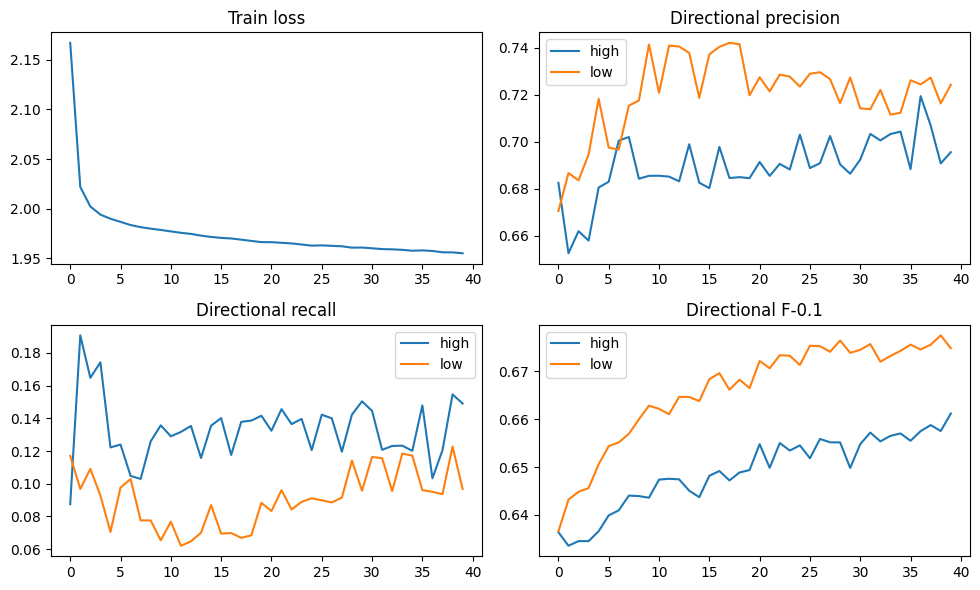

In [52]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(history["loss"])
plt.title("Train loss")

plt.subplot(2, 2, 2)
plt.plot(history["prec_H"], label="high")
plt.plot(history["prec_L"], label="low")
plt.title("Directional precision")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history["rec_H"], label="high")
plt.plot(history["rec_L"], label="low")
plt.title("Directional recall")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history["f05_H"], label="high")
plt.plot(history["f05_L"], label="low")
plt.title(f"Directional F-{METRIC_BETA}")
plt.legend()

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "training_curves.png", dpi=120)
plt.show
#plt.close()
print("Saved training_curves.png inside the prediction_model folder.")

### Final test metrics

In [53]:
ckpt = torch.load(Path(OUTPUT_DIR) / "model.pt", map_location=DEVICE)
model.load_state_dict(ckpt["state_dict"])
τH, τL = ckpt["thr_high"], ckpt["thr_low"]
model.eval()

yH_true, yH_pred = [], []
yL_true, yL_pred = [], []

with torch.no_grad():
    for X, yH, yL, item_id in dl_test:
        X = X.to(DEVICE)
        item_id = item_id.to(DEVICE)
        outH, outL = model(X, item_id)

        probsH = torch.softmax(outH, dim=1)
        probsL = torch.softmax(outL, dim=1)

        maxH, predH_raw = probsH.max(dim=1)
        maxL, predL_raw = probsL.max(dim=1)

        predH = torch.where(maxH < τH, torch.tensor(1, device=DEVICE), predH_raw)
        predL = torch.where(maxL < τL, torch.tensor(1, device=DEVICE), predL_raw)

        yH_true.extend(yH.numpy()); yH_pred.extend(predH.cpu().numpy())
        yL_true.extend(yL.numpy()); yL_pred.extend(predL.cpu().numpy())

def report(head, y_true, y_pred):
    labels = [0,1,2]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"\nConfusion matrix – {head}")
    print(pd.DataFrame(cm, index=[f"true_{c}" for c in labels],
                            columns=[f"pred_{c}" for c in labels]).to_string())

    prec, rec, f1, supp = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    df = pd.DataFrame(
        {"precision": prec, "recall": rec, "f1-score": f1, "support": supp},
        index=[f"class_{c}" for c in labels]
    )
    macro = pd.Series(
        {"precision": prec.mean(), "recall": rec.mean(),
            "f1-score": f1.mean(), "support": supp.sum()},
        name="macro_avg"
    )
    print(f"\nPrecision/Recall/F1 – {head}")
    print(pd.concat([df, macro.to_frame().T]).round(3).to_string())

report("HIGH", yH_true, yH_pred)
report("LOW" , yL_true, yL_pred)


Confusion matrix – HIGH
        pred_0  pred_1  pred_2
true_0    1577    5605     154
true_1    1221   24996     314
true_2     708    6292     440

Precision/Recall/F1 – HIGH
           precision  recall  f1-score  support
class_0        0.438   0.215     0.288   7336.0
class_1        0.661   0.942     0.777  26531.0
class_2        0.468   0.059     0.105   7440.0
macro_avg      0.522   0.405     0.390  41307.0

Confusion matrix – LOW
        pred_0  pred_1  pred_2
true_0     865    5849      92
true_1     564   26593     218
true_2     384    6349     357

Precision/Recall/F1 – LOW
           precision  recall  f1-score  support
class_0        0.463   0.127     0.199   6806.0
class_1        0.669   0.971     0.792  27375.0
class_2        0.518   0.050     0.092   7090.0
macro_avg      0.550   0.383     0.361  41271.0


## Model Experimenting

### Config

In [ ]:
MAX_HOLD_H     = 48 # hours
START_GP       = 100_000_000
ALLOC_FRAC     = 0.33
VOL_FRAC       = 0.30
MAX_OPEN_POS   = 100

START_TEST     = pd.Timestamp("2025-05-23")
END_TEST       = pd.Timestamp("2025-05-29 23:59:59")

### Helpers

In [55]:
def taxed_exit(gp_raw: float) -> float:
    return gp_raw * 0.99


def max_dd(equity: np.ndarray) -> float:
    peak = equity[0]
    mdd = 0.0
    for v in equity:
        peak = max(peak, v)
        mdd = min(mdd, v / peak - 1)
    return mdd

def record_trade(trades, *, item, entry_t, exit_t, qty, cost_gp, exit_gp, forced=False):
    """Append a closed trade to the list"""
    trades.append({
        "item": item,
        "entry": entry_t,
        "exit": exit_t,
        "qty": qty,
        "gp_in": cost_gp,
        "gp_out": exit_gp,
        "profit": exit_gp - cost_gp,
        "forced": forced,
    })

def dump_reports(trades, equity_curve, out_dir):
    """Win-rate, flips, per-item P&L, CSV files."""
    trades_df = pd.DataFrame(trades).sort_values("exit")
    flips = len(trades_df)
    win_rate = (trades_df["profit"] > 0).mean()
    forced_count = trades_df["forced"].sum()
    holds = trades_df["exit"] - trades_df["entry"]
    mean_hold = holds.mean()
    mean_hours = mean_hold.total_seconds() / 3600
    optional_count = len(trades_df) - forced_count

    pnl_item = (
        trades_df.groupby("item")["profit"]
        .agg(trades="count", total_gp="sum")
        .sort_values("total_gp", ascending=False)
    )

    eq = np.asarray(equity_curve)
    dd = max_dd(eq)

    print("\nRESULTS")
    print(f"Final equity : {eq[-1]:,.0f} gp")
    print(f"Return : {(eq[-1] / eq[0] - 1):.2%}")
    print(f"Draw-down : {dd:.2%}")
    print(f"Win-rate : {win_rate:.2%}")
    print(f"Total flips : {flips}")
    print(f"Forced closed: {forced_count}")
    print(f"Mean length : {mean_hours:.2f} hours")
    print("\nP&L BY ITEM")
    print(pnl_item.to_string())

    out_dir.mkdir(parents=True, exist_ok=True)
    trades_df.to_csv(out_dir / "trades.csv", index=False)
    pnl_item.to_csv(out_dir / "item_pnl.csv")
    print(f"\nCSV reports saved to {out_dir}")

### Plotting

In [56]:
def plot_equity_curve(equity_curve: list[float],
                      timestamps: list[pd.Timestamp]) -> None:
    eq_ser = pd.Series(equity_curve,
                       index=pd.DatetimeIndex(timestamps))

    # drop the duplicates that cause vertical artefacts
    eq_ser = eq_ser[~eq_ser.index.duplicated(keep="last")]

    plt.figure(figsize=(12, 6))
    plt.plot(eq_ser.index, eq_ser.values, linewidth=1.2)
    plt.title("Back-test Equity Curve")
    plt.xlabel("Time")
    plt.ylabel("Equity (gp)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / "equity_curve.png", dpi=120)

### Load artifacts

In [57]:
trades = []
equity_curve = []
equity_timestamps = []

sd = pickle.load(open(Path(OUTPUT_DIR) / "scaler.pkl", "rb"))
scaler = StandardScaler()
scaler.mean_, scaler.scale_ = sd["mean"], sd["scale"]
feat_cols   = sd["feat_cols"]
trained_items = [df["item_name"].iloc[0] for df in item_dfs] #sd["trained_items"]
item2idx = {name: i for i, name in enumerate(trained_items)}

ckpt = torch.load(Path(OUTPUT_DIR) / "model.pt", map_location=DEVICE)
model = LSTMClassifier(n_features=len(feat_cols), n_items=len(trained_items)).to(DEVICE)
model.load_state_dict(ckpt["state_dict"])
model.eval()
TAU_HIGH = ckpt["thr_high"]
TAU_LOW  = ckpt["thr_low"]

### Load and prepare item data

In [ ]:
all_rows      = [] # per-row dicts for global stream
feats_store   = {} # item_name ➜ np.ndarray(features)
last_mid      = {} # item_name ➜ live mid price (MTM)
item_lengths  = {} # item_name ➜ len(df)

# same hourly grid you used for training, but wider for context
full_idx = pd.date_range(
    START_TEST - pd.Timedelta(hours=SEQ_LEN),
    END_TEST + pd.Timedelta(hours=PRED_HORIZON),
    freq="H"
)
total_expected = len(full_idx)

for fp in glob.glob(os.path.join(INPUT_DIR, "*.csv")):
    name = Path(fp).stem
    if name not in trained_items:
        continue

    df = pd.read_csv(fp)
    if "datetime" not in df.columns:
        continue

    # basic cleaning

    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df = df.dropna(subset=["datetime"])
    df = df.set_index("datetime")

    # keep only the wide test window
    df = df[df.index.to_series().between(full_idx[0], full_idx[-1])]
    if df.empty:
        continue

    # completeness check

    #high_cnt = df["avgHighPrice"].count()
    #low_cnt  = df["avgLowPrice"].count()
    #if (high_cnt / total_expected < 0.9) or (low_cnt / total_expected < 0.9):
        # skip items that were rejected in training
    #    continue

    # re-index & impute
    df = df.reindex(full_idx) # exact hourly grid
    df.index.name = "datetime"

    # forward-fill prices
    df["avgHighPrice"] = df["avgHighPrice"].ffill()
    df["avgLowPrice"] = df["avgLowPrice"].ffill()

    # zero-fill volumes (no trades that hour)
    df["highPriceVolume"] = df["highPriceVolume"].fillna(0)
    df["lowPriceVolume"] = df["lowPriceVolume"].fillna(0)

    # carry metadata forward/backward
    df["item_name"] = name
    if "item_id" in df.columns:
        df["item_id"] = df["item_id"].ffill().bfill()

    # final length check (should always pass now)
    if len(df) != total_expected:
        continue

    # feature engineering & storage

    df = df.reset_index() # back to column “datetime”
    df, feat_cols = engineer_features(df)
    feats_store[name] = scaler.transform(
        df[feat_cols].values.astype(np.float32)
    )

    item_lengths[name] = len(df)
    last_mid[name] = np.nan # filled online

    # rows for the global, time-ordered stream
    rows = df[["datetime", "item_name", "mid", "highPriceVolume"]].copy()
    rows["row_idx"] = np.arange(len(df))
    rows["item_idx"] = item2idx[name]
    all_rows.append(rows)

# global stream sorted by wall-clock time
stream = (
    pd.concat(all_rows)
      .sort_values("datetime")
      .reset_index(drop=True)
)

print(f"Loaded {stream['item_name'].nunique()} items, {len(stream):,} rows in event stream.")

/tmp/ipykernel_28719/537743999.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(


Loaded 294 items, 57,330 rows in event stream.


### Backtest loop

In [59]:
cash = START_GP
open_pos: Dict[str, dict] = {}
equity_curve.append(cash)
equity_timestamps.append(START_TEST)
pbar = tqdm(total=len(stream), desc="Simulating")

for row in stream.itertuples(index=False):
    pbar.update(1)
    t = row.datetime
    if START_TEST <= t <= END_TEST:
        mtm = sum(
            pos["qty"] * last_mid[name]
            for name, pos in open_pos.items()
            if not np.isnan(last_mid[name])
        )
        equity_curve.append(cash + mtm)
        equity_timestamps.append(t)

    item_name = row.item_name
    item_idx = row.item_idx
    idx_in_item = row.row_idx
    mid_price = row.mid
    vol_hour = row.highPriceVolume

    # update last seen price for this item
    if not np.isnan(mid_price):
        last_mid[item_name] = mid_price

    # skip until in live test window and enough history for a prediction
    if not (START_TEST <= t <= END_TEST):
        continue
    if idx_in_item < SEQ_LEN or idx_in_item + PRED_HORIZON >= item_lengths[item_name]:
        continue

    # model forecast

    X_np = feats_store[item_name][idx_in_item - SEQ_LEN : idx_in_item]
    if np.isnan(X_np).any():
        continue
    X = torch.from_numpy(X_np).unsqueeze(0).to(DEVICE)  # (1, T, F)
    with torch.no_grad():
        outH, outL = model(X, torch.tensor([item_idx], device=DEVICE))
        pH = torch.softmax(outH, 1)[0]
        pL = torch.softmax(outL, 1)[0]
    predH, confH = int(pH.argmax()), float(pH.max())
    predL, confL = int(pL.argmax()), float(pL.max())

    bullish = (
        predH == 2 and predL == 2 and
        confH >= TAU_HIGH and confL >= TAU_LOW
    )
    bearish = (
        predH == 0 and predL == 0 and
        confH >= TAU_HIGH and confL >= TAU_LOW
    )

    # manage open position

    if item_name in open_pos:
        pos = open_pos[item_name]
        held_hours = (t - pos["entry_time"]).total_seconds() / 3600.0
        if bearish or held_hours >= MAX_HOLD_H:
            exit_gp_raw = pos["qty"] * mid_price
            proceeds = taxed_exit(pos["qty"] * mid_price)
            record_trade(
                trades,
                item=item_name,
                entry_t=pos["entry_time"],
                exit_t=t,
                qty=pos["qty"],
                cost_gp=pos["cost"],
                exit_gp=proceeds,
                forced = (held_hours >= MAX_HOLD_H)
            )
            cash += proceeds
            del open_pos[item_name]

    # open new position

    if bullish and item_name not in open_pos and len(open_pos) < MAX_OPEN_POS:
        if np.isnan(mid_price) or mid_price == 0:
            pass # skip if price bad
        else:
            volume_cap = int(vol_hour * VOL_FRAC)
            max_qty_cash = int((cash * ALLOC_FRAC) // mid_price)
            qty = min(volume_cap, max_qty_cash)
            if qty > 0:
                total_cost = qty * mid_price
                cash -= total_cost
                open_pos[item_name] = {
                    "entry_time": t,
                    "idx": idx_in_item,
                    "qty": qty,
                    "cost": total_cost,
                    "closed": False,
                }

pbar.close()

# Force close remaining positions

for name, pos in list(open_pos.items()):
    last_px = last_mid.get(name, np.nan)
    if np.isnan(last_px):
        continue
    proceeds = taxed_exit(pos["qty"] * last_px)
    cash    += proceeds
    pos["exit_time"] = END_TEST
    pos["gp_out"] = proceeds
    pos["profit"] = proceeds - pos["cost"]
    pos["closed"] = True
    #equity_curve.append(cash)
    #equity_timestamps.append(t)
    del open_pos[name]

equity_curve.append(cash)
equity_timestamps.append(END_TEST)

Simulating: 100%|██████████| 57330/57330 [01:41<00:00, 563.47it/s] 


### Reporting


RESULTS
Final equity : 113,847,475 gp
Return : 13.85%
Draw-down : -4.38%
Win-rate : 71.51%
Total flips : 172
Forced closed: 50
Mean length : 27.73 hours

P&L BY ITEM
                                trades     total_gp
item                                               
Avantoe potion (unf)                 4  1797299.630
Irit potion (unf)                    4  1638653.090
Red chinchompa                       4  1162538.355
Dwarf weed potion (unf)              1  1080568.700
Stamina potion(4)                    3   904313.270
Toadflax potion (unf)                4   749561.570
Bloodbark legs                       3   726636.930
Dragonstone bolt tips                4   692198.160
Smouldering stone                    3   682108.600
Cadantine potion (unf)               3   633066.925
Anti-venom(4)                        2   522818.730
Blood moon helm                      3   504178.325
Obsidian platebody                   2   487808.065
Anguish ornament kit                 2   462096.720
S

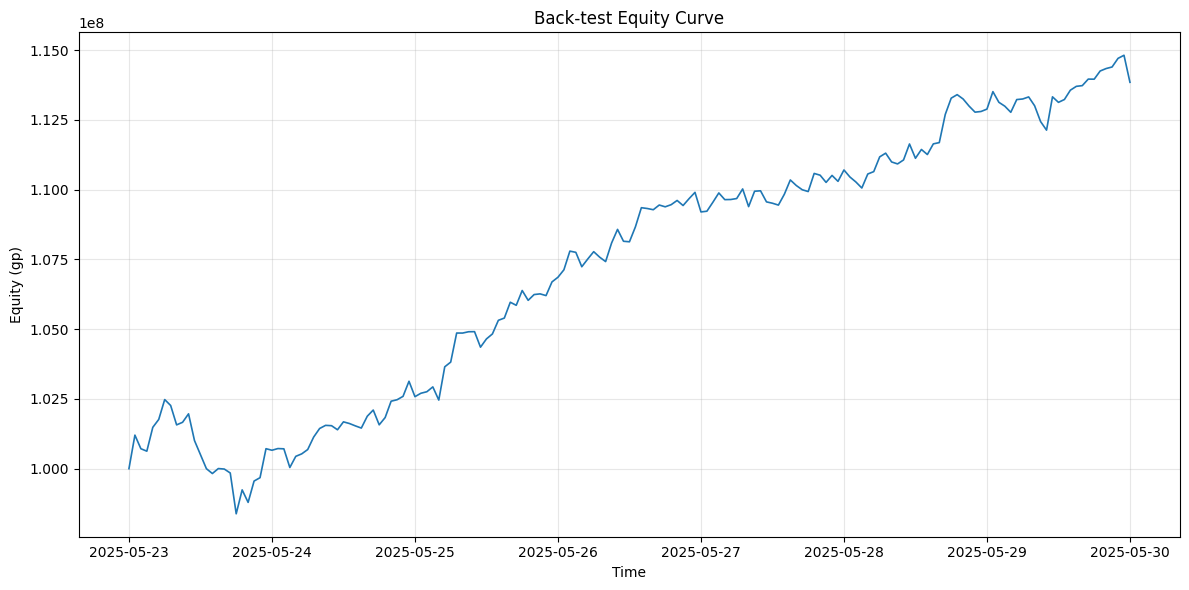

In [60]:
equity = np.array(equity_curve)
#print("\n── Global results ──")
#print(f"Final equity   : {cash:,.0f} gp  (start {START_GP:,.0f})")
#print(f"Total return   : {(cash / START_GP - 1):.2%}")
#print(f"Max draw‑down  : {max_dd(equity):.2%}")

# build trades dataframe from positions we closed
closed_positions = [pos for pos in last_mid.keys()  # placeholder
                    if False]  # TODO – retained for possible extensions

out_dir = Path(OUTPUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
dump_reports(trades, equity_curve, Path(OUTPUT_DIR))
plot_equity_curve(equity_curve, equity_timestamps)